In [175]:
%matplotlib inline
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import copy
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

In [176]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        print(f"Device: {str(self.device).upper()}")

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [177]:
def train_and_validate(nn, train_loader, val_loader, criterion, optimizer, num_epochs, print_seperate = False) -> None:
    """
    Train and validate a neural network model.

    Parameters:
    - nn : torch.nn.Module
        The neural network model to train and validate.
    - train_loader : DataLoader
        The DataLoader containing the training dataset.
    - val_loader : DataLoader
        The DataLoader containing the validation dataset.
    - criterion : torch.nn.Module
        The loss function to use.
    - optimizer : torch.optim.Optimizer
        The optimizer to use.
    - num_epochs : int
        The number of epochs to train the model.
    """
    
    nn.to(nn.device)
    
    n = int(len(str(abs(num_epochs))))

    for epoch in range(num_epochs):
        nn.train()
        total_train_loss = 0

        ind = 0
        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(nn.device), labels.to(nn.device)

            optimizer.zero_grad()  
            outputs = nn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  
            optimizer.step()  

            total_train_loss += loss.item()
            print(f"\rTraining.. Epoch [{epoch+1:>n}/{num_epochs:>n}], ({ind+1:>3}/{len(train_loader)})", end = "")
            ind += 1

        nn.eval()
        total_val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            ind = 0
            for batch in val_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(nn.device), labels.to(nn.device)

                outputs = nn(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
                print(f"\rValidating Epoch [{epoch+1:>n}/{num_epochs:>n}], ({ind+1:>3}/{len(val_loader):>3})", end = "")
                ind += 1

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        accuracy = correct_predictions / total_predictions

        print(f'\r.......... Epoch [{epoch+1:>n}/{num_epochs:>n}], ({len(val_loader):>3}/{len(val_loader):>3}), Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy*100:.2f}%', end = "")
        if print_seperate:
            print()
    print()

        


def test_model(nn, test_loader) -> None:
    """
    Test a neural network model on a given dataset.

    Parameters:
    - model : torch.nn.Module
        The trained neural network model to test.
    - test_loader : DataLoader
        The DataLoader for the test dataset.
    """


    print("\rTesting...", end = "")
    nn.to(nn.device)
    nn.eval()
    
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(nn.device), labels.to(nn.device)
            outputs = nn(inputs)
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Collect predictions and targets for computing metrics
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())





    # Compute precision, recall, F1 score, and confusion matrix
    accuracy = correct_predictions / total_predictions
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    

    # Print results
    print(f"Accuracy:  {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall:    {recall*100:.2f}%")
    print(f"F1 Score:  {f1*100:.2f}%")
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()



In [178]:
#local_directory = "C:/Users/hampu/Documents/kurser/år3/d7047e/images"
local_directory = "C:/Users/hampek/Documents/school/d7047e/images"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

full_dataset = ImageFolder(root=local_directory, transform=transform)

# 70/15/15 split
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True,  num_workers = num_workers)
val_loader   = DataLoader(val_dataset,   batch_size = batch_size, shuffle=False, num_workers = num_workers)
test_loader  = DataLoader(test_dataset,  batch_size = batch_size, shuffle=False, num_workers = num_workers)



Device: CPU
.......... Epoch [1/1], (  7/  7), Train Loss: 0.4625, Val Loss: 0.2165, Accuracy: 91.91%

Testing...Accuracy:  91.35%
Precision: 92.30%
Recall:    91.35%
F1 Score:  91.57%


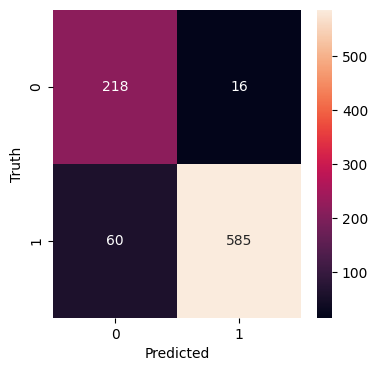

In [179]:
model = CNN()
num_epochs = 10
learning_rate = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, print_seperate=True)
test_model(model, test_loader)
